In [1]:
# Cntrl + f+ '1TODO' , 'TODO'

import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
#%matplotlib inline

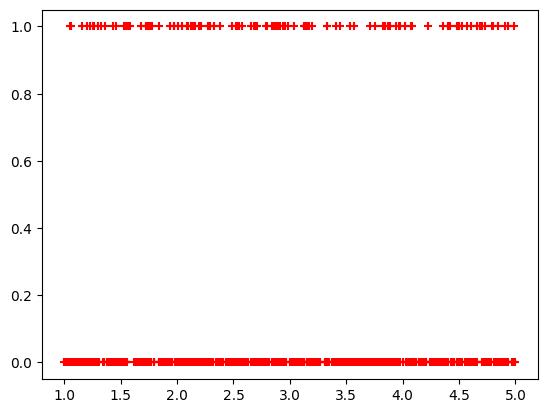

In [3]:
df = pd.read_csv('Subscription_Service_Churn_Dataset.csv')

df.head()
plt.scatter(df.UserRating,df.Churn,marker='+',color='red')

In [ ]:
#TODO: follow Rob Mulla's routine for data discovery
#2 TODO: pd.value_counts().unstack()

In [ ]:
# 1TODO:  lookup:

#  when splittingdata into x and y for analysis, how do I set y equal to the 
# 'Churn' column and x equal to all the other columns?

X = df.drop['Churn', axis=1]
y = df['Churn']

# Split the data into training and testing sets
# test_size specifies the proportion of the dataset to include in the test split
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (917431597.py, line 1)